In [2]:
#!pip install transformers torch pillow pandas matplotlib

import os
import json
from PIL import Image
import torch
import pandas as pd
import matplotlib.pyplot as plt
from transformers import BlipProcessor, BlipForConditionalGeneration


In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# BLIP VQA model
processor = BlipProcessor.from_pretrained("Salesforce/blip-vqa-base")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-vqa-base").to(device)

print("✅ Model BLIP VQA loaded on", device)


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

preprocessor_config.json:   0%|          | 0.00/445 [00:00<?, ?B/s]

C:\Users\Pongo\AppData\Roaming\Python\Python312\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Pongo\.cache\huggingface\hub\models--Salesforce--blip-vqa-base. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/1.54G [00:00<?, ?B/s]

✅ Model BLIP VQA loaded on cpu


In [5]:
with open("vqa_question.json", "r", encoding="utf-8") as f:
    q_data = json.load(f)

questions = q_data[0]["questions"]
print("Daftar pertanyaan VQA:", questions)


Daftar pertanyaan VQA: ['Does the image contain onomatopoeia text?', 'What text is written in the image?', 'What are the dominant colors of the water splash?']


In [6]:
base_dir = "dataset_eval/"
results = []

for exp in os.listdir(base_dir):
    exp_path = os.path.join(base_dir, exp)
    if not os.path.isdir(exp_path):
        continue
    
    for img_file in os.listdir(exp_path):
        if not img_file.lower().endswith((".png", ".jpg", ".jpeg")):
            continue
        
        img_path = os.path.join(exp_path, img_file)
        image = Image.open(img_path).convert("RGB")
        
        for q in questions:
            inputs = processor(image, q, return_tensors="pt").to(device)
            out = model.generate(**inputs)
            answer = processor.decode(out[0], skip_special_tokens=True)
            
            results.append({
                "experiment": exp,
                "image": img_file,
                "question": q,
                "answer": answer
            })

df_vqa = pd.DataFrame(results)
df_vqa.to_csv("vqa_results.csv", index=False)
df_vqa.head()


,experiment,image,question,answer
0,exp1_sd15_2050,Byur_00001_.png,Does the image contain onomatopoeia text?,does the image contain onomatopoeia text?
1,exp1_sd15_2050,Byur_00001_.png,What text is written in the image?,what text is written in the image?
2,exp1_sd15_2050,Byur_00001_.png,What are the dominant colors of the water splash?,what are the dominant colors of the water splash?
3,exp1_sd15_2050,Byur_00002_.png,Does the image contain onomatopoeia text?,does the image contain onomatopoeia text?
4,exp1_sd15_2050,Byur_00002_.png,What text is written in the image?,what text is written in the image?


In [7]:
# Tampilkan ringkasan jawaban
summary = df_vqa.groupby(["experiment", "question"])["answer"].apply(lambda x: x.value_counts().index[0]).reset_index()

print("Ringkasan jawaban per eksperimen & pertanyaan:")
display(summary)


Ringkasan jawaban per eksperimen & pertanyaan:


,experiment,question,answer
0,exp1_sd15_2050,Does the image contain onomatopoeia text?,does the image contain onomatopoeia text?
1,exp1_sd15_2050,What are the dominant colors of the water splash?,what are the dominant colors of the water splash?
2,exp1_sd15_2050,What text is written in the image?,what text is written in the image?
3,exp2_sd15_3050,Does the image contain onomatopoeia text?,does the image contain onomatopoeia text?
4,exp2_sd15_3050,What are the dominant colors of the water splash?,what are the dominant colors of the water splash?
5,exp2_sd15_3050,What text is written in the image?,what text is written in the image?
6,exp3_sd15_3050_v2,Does the image contain onomatopoeia text?,does the image contain onomatopoeia text?
7,exp3_sd15_3050_v2,What are the dominant colors of the water splash?,what are the dominant colors of the water splash?
8,exp3_sd15_3050_v2,What text is written in the image?,what text is written in the image?
9,exp4_sd15_3050_v3,Does the image contain onomatopoeia text?,does the image contain onomatopoeia text?


In [8]:
# Filter pertanyaan tertentu
q_filter = "Apakah terdapat teks onomatope di dalam gambar?"
subset = df_vqa[df_vqa["question"] == q_filter]

count_answers = subset.groupby(["experiment", "answer"]).size().unstack(fill_value=0)

count_answers.plot(kind="bar", stacked=True, figsize=(10,6))
plt.title("Distribusi Jawaban VQA per Eksperimen")
plt.ylabel("Jumlah Gambar")
plt.xlabel("Eksperimen")
plt.xticks(rotation=45)
plt.legend(title="Jawaban")
plt.show()


TypeError: no numeric data to plot

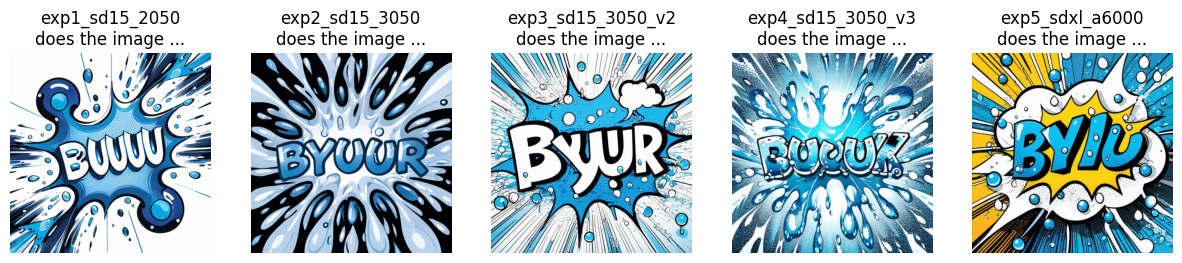

In [9]:
# Ambil contoh 1 gambar per eksperimen dengan jawaban VQA
sample = df_vqa.groupby("experiment").first().reset_index()

fig, axes = plt.subplots(1, len(sample), figsize=(15,5))
for i, row in enumerate(sample.itertuples()):
    img_path = os.path.join(base_dir, row.experiment, row.image)
    img = Image.open(img_path)
    axes[i].imshow(img)
    axes[i].set_title(f"{row.experiment}\n{row.answer[:15]}...")
    axes[i].axis("off")
plt.show()
